In [82]:
from scipy import signal
from scipy.stats import norm
import cupy as cp
import matplotlib.pyplot as plt 
import multiprocessing as mp
import numpy as np

label_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
		  'verticalalignment':'bottom'} 
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'bold'}
legend_font = {'family':'sans-serif', 'size':'10', 'style':'normal'} 

In [100]:
def applyFilter(cutoff, data, plotResponse = False):
	fs = len(data)
	#print(len(data[0]))
	#print('CUTOFF: ' + str(cutoff))
	fcNorm = 2./cutoff
	b, a = signal.butter(2,fcNorm, 'highpass', analog = False)

	if plotResponse:
		w, h = signal.freqz(b, a, worN = 2**18)
		plt.semilogx(1 / (w[1:] / (2*np.pi)), 20*np.log10(abs(h[1:])))
		plt.margins(0, 0.1)
		plt.xlim([10**5, 1])
		plt.gca().set_xticks([10**5, 10**4, 10**3, 10**2, 10**1, 10**0])
		plt.grid(which = 'both', axis = 'both')
		plt.axvline(cutoff, color = 'green')
		plt.xlabel('Number of Bins', labelpad = 15, **label_font)
		plt.ylabel('Amplitude (dB)', **label_font)
		plt.xticks(fontsize = 16)
		plt.yticks(fontsize = 16)
		#plt.savefig('FilteredResponse.png', bbox_inches = 'tight', dpi = 100)

		plt.show()
	response = np.asarray(signal.filtfilt(b, a, data), dtype = 'float64')
	#print('FILTER RESPONSE: ' + str(response))
	return response

def compGaussCDF(zscore):
	return norm.cdf(zscore)

# Calculate the integral of the data between succeeding step points.
def calcSigHeights(steps, mean, std):
	oldCDF = 0 
	sigPoints = []
	for val in steps:
		newCDF = compGaussCDF((val - mean)/std)
		integralVal = newCDF - oldCDF
		sigPoints.append(integralVal)
		oldCDF = newCDF
	sigPoints[0] = 0
	return np.asarray(sigPoints)

def genGaussData(noiseLength, logUnits = False):
	mean = 0
	std = 1

	# Generate Gaussian random noise
	noiseSamples = np.random.normal(loc = mean, scale = std, size = noiseLength)


	# Do FFT and normalize
	dataFFT = np.abs(np.fft.fft(noiseSamples, n = noiseLength, norm = None)[:int(noiseLength/2)+1])**2
	dataFFT = 1./(noiseLength**2)*np.asarray([x if (counter == 0 or counter == len(dataFFT) -1) else 2*x for counter, x in enumerate(dataFFT)])
	
	# Convert to dBm if needed
	if logUnits:
		dataFFT = 10*np.log10(dataFFT*1000)
	
	return dataFFT

def genGaussDataGPU(noiseLength, index, logUnits = False):
	mean = 0
	std = 1
	if not(index):
		cp.random.seed()
		print('SEEDED RNG')
	# cp.random.seed()
	# Generate Gaussian random noise
	#print('STARTED RANDOM!')
	noiseSamples = cp.random.normal(loc = mean, scale = std, size = noiseLength)
	#print('ENDED RANDOM!')

	# Do FFT and normalize
	#print('STARTED FFT!')
	dataFFT = 2./noiseLength**2*cp.abs(cp.fft.fft(noiseSamples, n = noiseLength, norm = None)[:int(noiseLength/2)+1])**2
	#print('ENDED FFT!')
	#dataFFT = 1./(noiseLength**2)*cp.asarray([x if (counter == 0 or counter == len(dataFFT) -1) else 2*x for counter, x in enumerate(dataFFT)])
	# Convert to dBm if needed
	if logUnits:
		dataFFT = 10*np.log10(dataFFT*1000)
	
	return dataFFT

def getSNR(fftLength, totalAvg, index):
	print('ON RUN ' + str(index))
	np.random.seed()
	ampSig = 0.0001
	fs = 2**10*100
	# Set the mean to 0 for right now
	maxZ = 3 
	minZ = -3
	normMean = 0
	stepSize = fs / fftLength
	normSTD = 100
	sigSteps = np.arange(minZ * normSTD, maxZ * normSTD + 0.99*stepSize, stepSize)
	sigPoints = calcSigHeights(sigSteps, normMean, normSTD)
	#print(sigPoints)
	maxIndex = np.argmax(sigPoints)
	paddedSignal = ampSig * np.pad(sigPoints, (int(fftLength/4 - maxIndex), int(fftLength/4 - (len(sigPoints) - maxIndex - 1))), 'constant', constant_values=(0, 0))		
	#freqs = np.arange(0, fs/2 + stepSize, stepSize)
	#plt.plot(freqs, paddedSignal)
	#plt.show()
	noiseData = np.zeros(int(fftLength/2) + 1)
	for x in range(totalAvg):
		noiseData += genGaussData(fftLength)
	noiseData = noiseData/totalAvg + (paddedSignal)
	convSignal = np.convolve((noiseData), sigPoints[::-1], mode = 'same')
	#print(convSignal)
	#print('DONKEY')
	#print(len(convSignal))
	cutoff = 100*2**(int(np.log2(fftLength)-10))
	#if cutoff > 3000:
	#	cutoff = 3000
	filteredConv = applyFilter(cutoff, convSignal[int(fftLength/20):-int(fftLength/20)], plotResponse = False)
	#print(filteredConv)
	#print('LLAMA')
	plt.plot(filteredConv)
	#plt.plot([np.argmax(filteredConv)], [max(filteredConv)], 'r*')
	guessSigma = np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)])
	guessMean = np.mean(np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)]))
	snrVal = ((max(filteredConv) - guessMean)/guessSigma)
	plt.show()
	return snrVal

def genPaddedSignal(fftLength):
	ampSig = 0.0002
	fs = 2**10*100
	# Set the mean to 0 for right now
	maxZ = 3 
	minZ = -3
	normMean = 0
	stepSize = fs / fftLength
	normSTD = 100
	print('GENERATING SIGNAL STEPS')
	sigSteps = np.arange(minZ * normSTD, maxZ * normSTD + 0.99*stepSize, stepSize)
	sigPoints = calcSigHeights(sigSteps, normMean, normSTD)
	print('DONE GENERATING SIGNAL STEPS')
	#print(sigPoints)
	#plt.plot(sigPoints)
	#plt.show()
	maxIndex = np.argmax(sigPoints)
	paddedSignal = ampSig * np.pad(sigPoints, (int(fftLength/4 - maxIndex), int(fftLength/4 - (len(sigPoints) - maxIndex - 1))), 'constant', constant_values=(0, 0))		
	return sigPoints, paddedSignal

def getSNRGPU(fftLength, totalAvg, sigPoints, paddedSignal, index):
	print('ON RUN ' + str(index))
	np.random.seed()
	#ampSig = 0.002
	#freqs = np.arange(0, fs/2 + stepSize, stepSize)
	#plt.plot(freqs, paddedSignal)
	#plt.show()
	noiseData = cp.zeros(int(fftLength/2) + 1)
	for x in range(totalAvg):
		noiseData += genGaussDataGPU(fftLength, x)
	noiseData = noiseData/totalAvg + cp.asarray(paddedSignal)
	#plt.plot(noiseData.get())
	#plt.show()
	convSignal = cp.convolve((noiseData), cp.asarray(sigPoints[::-1]), mode = 'same').get()
	#print(convSignal)
	#print('DONKEY')
	#print(len(convSignal))
	cutoff = 100*2**(int(np.log2(fftLength)-10))
	#if cutoff > 1000:
	#	cutoff = 1000
	filteredConv = applyFilter(cutoff, convSignal[int(fftLength/20):-int(fftLength/20)], plotResponse = False)
	#print(filteredConv)
	#print('LLAMA')
	#plt.plot( convSignal[int(fftLength/20):-int(fftLength/20)])
	#plt.plot([np.argmax(filteredConv)], [max(filteredConv)], 'r*')
	guessSigma = np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)])
	guessMean = np.mean(np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)]))
	snrVal = ((max(filteredConv) - guessMean)/guessSigma)
	#plt.show()
	#plt.plot(filteredConv)
	#plt.show()
	print('SNR VAL: ' + str(snrVal))
	return snrVal

[99.9488     99.9490002  99.94920039 99.94940059 99.94960078 99.94980098
 99.95000117 99.95020137 99.95040156 99.95060176]
[100.04949824 100.04969844 100.04989863 100.05009883 100.05029902
 100.05049922 100.05069941 100.05089961 100.0510998  100.0513    ]
0.001881391968010274
0.001953125
0.0018509819197395918


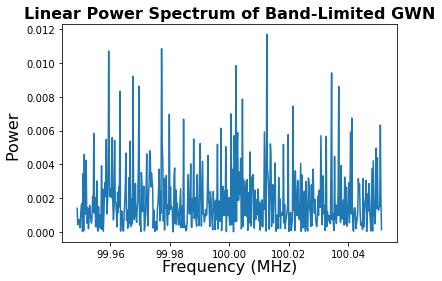

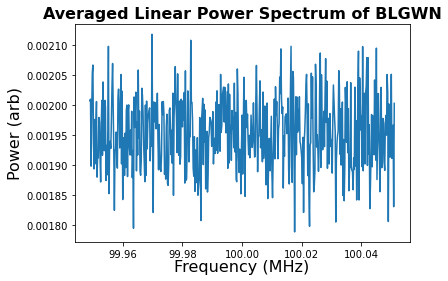

In [84]:
noiseLength = 2**10
# Initially assume that our resolution is 1ppm 
centerFreq = 100 # In MHz
stepSize = centerFreq/10**6 

freqs = np.linspace(centerFreq - stepSize*noiseLength/2, centerFreq + stepSize*noiseLength/2 + stepSize, int(noiseLength/2) + 1)
print(freqs[0:10])
print(freqs[-10:])
noiseData = genGaussData(noiseLength)
#print(np.std(noiseData)**2)

# Notice that the mean value of the FFT is equal to the variance (which is one) with
# some prefactors
print(np.mean(noiseData))
print(2/noiseLength)

print(np.std(noiseData))

plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.plot(freqs, noiseData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power ', **label_font)
plt.title('Linear Power Spectrum of Band-Limited GWN', **title_font)
plt.show()
#input('PRESS ENTER TO CONTINUE:')


# Take some averages
totalAvg = 1000
noiseData = np.zeros(int(noiseLength/2) + 1)
for x in range(totalAvg):
	noiseData += genGaussData(noiseLength)

# Plot the spectrum
plt.plot(freqs[1:-1], ((noiseData/totalAvg))[1:-1])
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power (arb)', **label_font)
plt.title('Averaged Linear Power Spectrum of BLGWN', **title_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

[-9.00000000e-04 -8.00000000e-04 -7.00000000e-04 -6.00000000e-04
 -5.00000000e-04 -4.00000000e-04 -3.00000000e-04 -2.00000000e-04
 -1.00000000e-04  3.25260652e-19  1.00000000e-04  2.00000000e-04
  3.00000000e-04  4.00000000e-04  5.00000000e-04  6.00000000e-04
  7.00000000e-04  8.00000000e-04  9.00000000e-04]


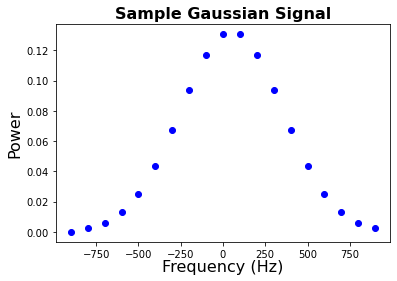

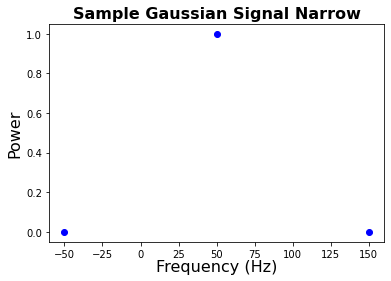

In [85]:
# Now let's add a signal in the frequency domain. We can do this because the DFT
# is power preserving. Assume that the signal is Gaussian, and normalized so that the total
# energy of the signal is a * standard deviation of the noise
# For right now, set the standard deviation to be equal to the 3x the 
# resolution of our FFT (1ppm) or 300 Hz. 
# We are also only going to compute to +/-3 standard deviations.

# Set the width to be wider to show the process

normSTD = stepSize * 3

# Set the mean to 0 for right now
normMean = 0

# Min and max z values
minZ = -3
maxZ = 3

# Total energy of our signal in units of standard deviation of the white noise
energyZ = 5

# Sample frequencies at multiples of our minimum sampling resolution.
# Right now, this is centered around 0, but can be shifted as needed.
steps = np.arange(minZ * normSTD, maxZ * normSTD + stepSize, stepSize)
print(steps)



oldCDF = 0
sigPoints = calcSigHeights(steps, normMean, normSTD)
plt.plot(steps*10**6, sigPoints, 'bo')
plt.xlabel('Frequency (Hz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.title('Sample Gaussian Signal', **title_font)
plt.show()

# See what happens if the signal is narrowed
normSTD = stepSize / 6
steps = np.arange(minZ * normSTD, maxZ * normSTD + 1.01*stepSize, stepSize)
sigPoints = calcSigHeights(steps, normMean, normSTD)
plt.plot(steps*10**6, sigPoints, 'bo')
plt.xlabel('Frequency (Hz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.title('Sample Gaussian Signal Narrow', **title_font)
plt.show()

[-9.00000000e-04 -8.00000000e-04 -7.00000000e-04 -6.00000000e-04
 -5.00000000e-04 -4.00000000e-04 -3.00000000e-04 -2.00000000e-04
 -1.00000000e-04  3.25260652e-19  1.00000000e-04  2.00000000e-04
  3.00000000e-04  4.00000000e-04  5.00000000e-04  6.00000000e-04
  7.00000000e-04  8.00000000e-04  9.00000000e-04]


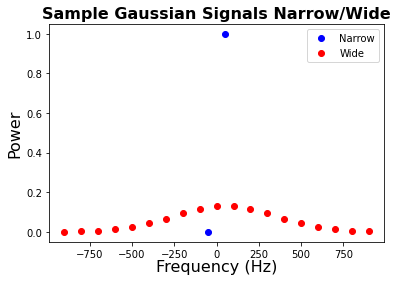

In [86]:
# Overlap two signals to see the process
normSTDNarrow = stepSize / 6
normSTDWide = stepSize * 3
stepsNarrow = np.arange(minZ * normSTDNarrow, maxZ * normSTDNarrow + 0.99*stepSize, stepSize)
sigPointsNarrow = calcSigHeights(stepsNarrow, normMean, normSTDNarrow)
stepsWide = np.arange(minZ * normSTDWide, maxZ * normSTDWide + 0.99*stepSize, stepSize)
print(stepsWide)
sigPointsWide = calcSigHeights(stepsWide, normMean, normSTDWide)

plt.plot(stepsNarrow*10**6, sigPointsNarrow, 'bo', label = 'Narrow')
plt.plot(stepsWide*10**6, sigPointsWide, 'ro', label = 'Wide')

plt.xlabel('Frequency (Hz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.title('Sample Gaussian Signals Narrow/Wide', **title_font)
plt.legend(prop = legend_font)
plt.show()

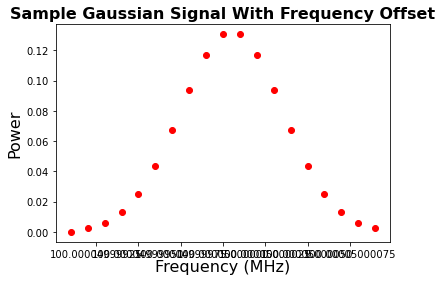

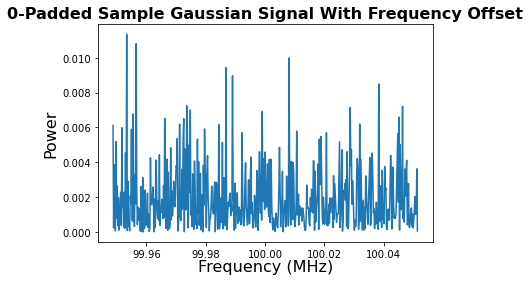

In [87]:
# Now let's align the maximum bin with our frequency axis
maxIndex = np.argmax(sigPointsWide)
offset = freqs[int(len(freqs)/2)]*10**6 - stepsWide[maxIndex] 
plt.plot((stepsWide + offset)/10**6, sigPointsWide, 'ro')
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Sample Gaussian Signal With Frequency Offset', **title_font)
plt.show()


# Increase the length of the signal to be the same as the noise signal
noiseLength = 2**10

# Set the total energy of the signal
ampSig = 5*(2/noiseLength)

paddedSignal = ampSig  * np.pad(sigPointsWide, (int(noiseLength/4 - maxIndex), int(noiseLength/4 - (len(sigPointsWide) - maxIndex - 1))), 'constant', constant_values=(0, 0))
noiseData = genGaussData(noiseLength)
centerFreq = 100 # In MHz
stepSize = centerFreq/10**6 
freqs = np.linspace(centerFreq - stepSize*noiseLength/2, centerFreq + stepSize*noiseLength/2 + stepSize, int(noiseLength/2) + 1)
plt.plot(freqs, paddedSignal + noiseData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('0-Padded Sample Gaussian Signal With Frequency Offset', **title_font)
plt.show()

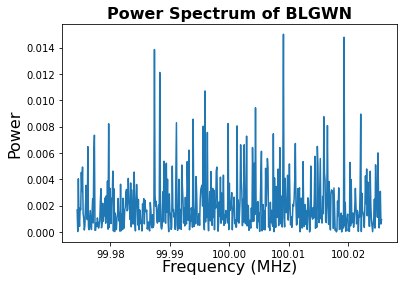

In [88]:
# Now we actually have to do an FFT. I'm going to do this 'correctly' so we don't have
# to arbitrarily add in multiplicative factors. And I'm going to assume perfect mixing.
# Assume we want a 1 ppm signal at 100 MHz and are doing a length 2^10 FFT. We need
# a resolution of 100 Hz. So, set our sampling rate at (2**10*100) is about 100 kHz.
# At the end, we'll offset everything.

fftLength = 2**10
fs = 2**10*100
stepSize = fs / fftLength

freqs = np.asarray(range(int(fftLength/2)+1)) * stepSize
offset = 1E8 - np.median(freqs)
freqs += offset

noiseData = genGaussData(fftLength)

plt.plot(freqs/10**6, noiseData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Power Spectrum of BLGWN', **title_font)
plt.show()

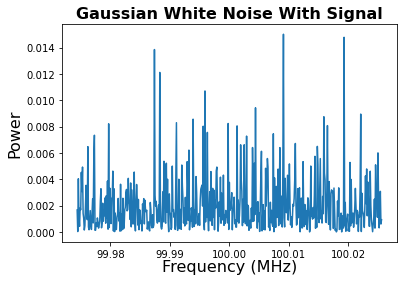

In [89]:
# Add in a signal now
normSTD = 50 # In Hz

# Set the mean to 0 for right now
normMean = 0

# Min and max z values
minZ = -3
maxZ = 3

# Total energy of our signal (arb)
ampSig = 0.0001


sigSteps = np.arange(minZ * normSTD, maxZ * normSTD + 0.99*stepSize, stepSize)
sigPoints = calcSigHeights(sigSteps, normMean, normSTD)
maxIndex = np.argmax(sigPoints)
paddedSignal = ampSig * np.pad(sigPoints, (int(fftLength/4 - maxIndex), int(fftLength/4 - (len(sigPoints) - maxIndex - 1))), 'constant', constant_values=(0, 0))


totalData = noiseData + paddedSignal
plt.plot(freqs/10**6, totalData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Gaussian White Noise With Signal', **title_font)
plt.show()

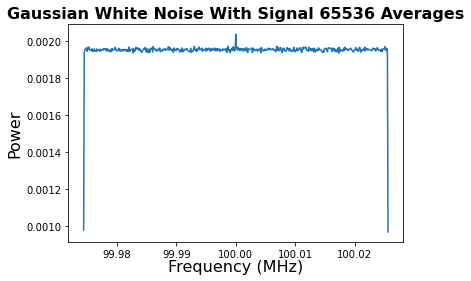

In [90]:
# Cannot see the signal very well, so do some averaging
noiseData = np.zeros(int(fftLength/2) + 1)
totalAvg = 2**10*2**6
for x in range(totalAvg):
	noiseData += genGaussData(fftLength)

noiseData = noiseData/totalAvg + paddedSignal

plt.plot(freqs/10**6, noiseData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Gaussian White Noise With Signal ' + str(totalAvg) + ' Averages', **title_font)
plt.show()

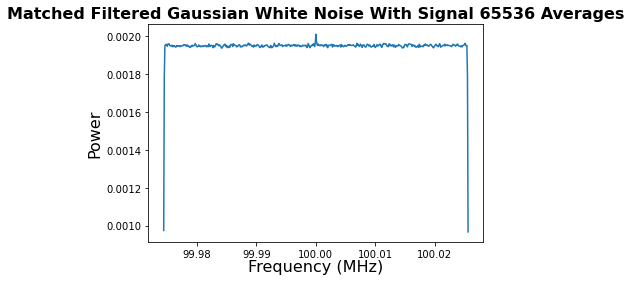

In [91]:
convSignal = np.convolve(noiseData, sigPoints[::-1], mode = 'same')
plt.plot(freqs/10**6, convSignal)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Matched Filtered Gaussian White Noise With Signal ' + str(totalAvg) + ' Averages', **title_font)
plt.show()

SNR: 10.7202


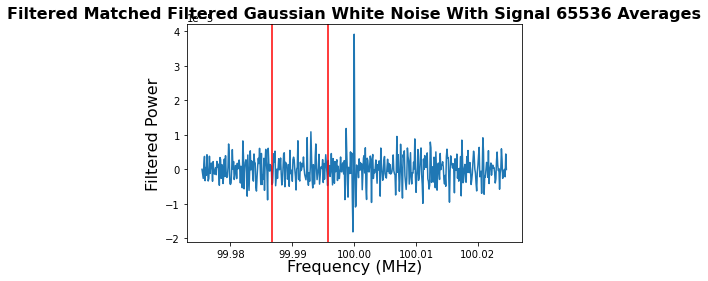

In [92]:
filteredConv = applyFilter(10, convSignal[10:-10])
plt.plot(freqs[10:-10]/10**6, filteredConv)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Filtered Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Filtered Matched Filtered Gaussian White Noise With Signal ' + str(totalAvg) + ' Averages', **title_font)
guessSigma = np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)])
guessMean = np.mean(np.std(filteredConv[int(len(filteredConv)/4):int(len(filteredConv)/2.3)]))
plt.axvline(x = freqs[int(len(filteredConv)/2.3)]/10**6, color = 'r')
plt.axvline(x = freqs[int(len(filteredConv)/4)]/10**6, color = 'r')
print('SNR: ' + str(round((max(filteredConv) - guessMean)/guessSigma, 4)))
plt.show()

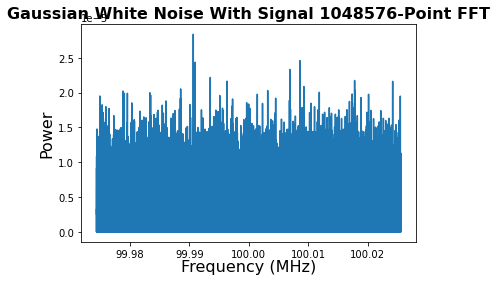

In [93]:
# Same thing but with a much longer FFT
fftLength = 2**20
numAvg = 2**6

stepSize = fs / fftLength
freqs = np.asarray(range(int(fftLength/2)+1)) * stepSize
noiseData = genGaussData(fftLength)
offset = 1E8 - np.median(freqs)
freqs += offset

sigSteps = np.arange(minZ * normSTD, maxZ * normSTD + 0.99*stepSize, stepSize)
sigPoints = calcSigHeights(sigSteps, normMean, normSTD)
maxIndex = np.argmax(sigPoints)
paddedSignal = ampSig * np.pad(sigPoints, (int(fftLength/4 - maxIndex), int(fftLength/4 - (len(sigPoints) - maxIndex - 1))), 'constant', constant_values=(0, 0))

totalData = noiseData + paddedSignal
plt.plot(freqs/10**6, totalData)
plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
plt.ylabel('Power', **label_font)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.title('Gaussian White Noise With Signal ' + str(fftLength) + '-Point FFT', **title_font)
plt.show()

In [ ]:
totalIts = 100
fftLength = 2**10
totalAvg = 2**10*2**6

#print(getSNR(2**10, 2**16))
#print('DONE')
pool = mp.Pool(processes=int(mp.cpu_count()))
snrVals = [pool.apply_async(getSNR, args=(fftLength, totalAvg, x)) for x in range(totalIts)]
#returnedObs = [getSNR(fftLength, totalAvg, x) for x in range(totalIts)]
pool.close()
pool.join()
#snrVals = [x.get() for x in returnedObs]
print(snrVals)

print('MEAN SNR: ' + str(np.mean(snrVals)))
print('MEDIAN SNR: ' + str(np.median(snrVals)))
print('MAX SNR: ' + str(max(snrVals)))
print('MIN SNR: ' + str(min(snrVals)))
print('STD OF SNR: ' + str(np.std(snrVals)))

In [102]:
totalIts = 100
fftLength = 2**10
totalAvg = 2**16
%matplotlib inline
#print(getSNRGPU(fftLength, totalAvg, 1))
#print('DOINK')
#sys.exit(1)

#pool = mp.Pool(processes=int(mp.cpu_count()))
print('GENERATING PADDED SIGNAL')
sigPoints, paddedSignal = genPaddedSignal(fftLength)
print('DONE GENERATING PADDED SIGNAL')
snrVals = [getSNRGPU(fftLength, totalAvg, sigPoints, paddedSignal, x) for x in range(totalIts)]
#pool.close()
#pool.join()
#snrVals = [x.get() for x in returnedObs]
#print(snrVals)

print('MEAN SNR: ' + str(np.mean(snrVals)))
print('MEDIAN SNR: ' + str(np.median(snrVals)))
print('MAX SNR: ' + str(max(snrVals)))
print('MIN SNR: ' + str(min(snrVals)))
print('STD OF SNR: ' + str(np.std(snrVals)))

GENERATING PADDED SIGNAL
GENERATING SIGNAL STEPS
DONE GENERATING SIGNAL STEPS
DONE GENERATING PADDED SIGNAL
ON RUN 0
SEEDED RNG
SNR VAL: 12.927862770855912
ON RUN 1
SEEDED RNG
SNR VAL: 11.358124888021287
ON RUN 2
SEEDED RNG
SNR VAL: 9.869565512038406
ON RUN 3
SEEDED RNG
SNR VAL: 16.35081939679782
ON RUN 4
SEEDED RNG
SNR VAL: 15.951587613663703
ON RUN 5
SEEDED RNG
SNR VAL: 12.718274390304927
ON RUN 6
SEEDED RNG
SNR VAL: 11.014770466986969
ON RUN 7
SEEDED RNG
SNR VAL: 12.861798173115348
ON RUN 8
SEEDED RNG
SNR VAL: 15.035601114470957
ON RUN 9
SEEDED RNG
SNR VAL: 10.928183100653749
ON RUN 10
SEEDED RNG
SNR VAL: 12.835968910329866
ON RUN 11
SEEDED RNG
SNR VAL: 14.216893807899991
ON RUN 12
SEEDED RNG
SNR VAL: 12.432950845308863
ON RUN 13
SEEDED RNG
SNR VAL: 10.469543068165514
ON RUN 14
SEEDED RNG
SNR VAL: 14.54667849066039
ON RUN 15
SEEDED RNG
SNR VAL: 13.072680032291508
ON RUN 16
SEEDED RNG
SNR VAL: 10.70763249636772
ON RUN 17
SEEDED RNG
SNR VAL: 14.51577060276664
ON RUN 18
SEEDED RNG
SNR 